### **PyTorch Implementation of DeepLOB for Limit Order Book Prediction**

This notebook is implementation of the DeepLOB model architecture in PyTorch. The goal is to predict short-term mid-price movements based on historical limit order book and trade data.

We will

1. **Load and preprocess data**  
   - Extract prices, volumes, and order counts for multiple LOB levels.
   - Label our data based on future price movements, applying smoothing to reduce noise and adress class imbalance.

2. **Feature engineering and scaling**  
   - Create a features of prices, volumes, imbalances, spreads etc..

3. **Define the DeepLOB architecture in PyTorch**
   - **Initial convolution layers:** to extract local spatial patterns from the LOB features.
   - **Inception modules:** to capture multi-scale temporal features at each time step.
   - **LSTM layer:** to learn how these features evolve over time, capturing longer-term temporal dependencies.
   - **Final dense layer (softmax output):** to predict the probability of each price movement class.

This approach is inspired by the *DeepLOB: Deep Convolutional Neural Networks for Limit Order Books* paper, adapting the architecture into PyTorch and extending it with custom features and data sources.

In [3]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', False)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

We use orderbook and trade data of ETH on HyperLiquid

In [15]:
LOB_LEVELS = 10
DATA_PATH = 'C:/Users/trgrd/OneDrive/Trading/Projects/data_download/hyp_data/ETH'
BOOK_FILES = ['ETH_book_20241108.pkl', 'ETH_book_20241109.pkl', 'ETH_book_20241110.pkl']
TRADE_FILES = ['ETH_trade_20241108.pkl', 'ETH_trade_20241109.pkl', 'ETH_trade_20241110.pkl']

# Function to load and concatenate multiple pickle files
def load_and_concat(files, data_path):
    return pd.concat([pd.DataFrame(pd.read_pickle(os.path.join(data_path, f))) for f in files], ignore_index=True)

# Load and concatenate book and trade data
ETH_book = load_and_concat(BOOK_FILES, DATA_PATH)
ETH_trades = load_and_concat(TRADE_FILES, DATA_PATH)

# Define column names for bids and asks
bid_price_cols = [f'BidPrice_{i+1}' for i in range(LOB_LEVELS)]
bid_volume_cols = [f'BidVolume_{i+1}' for i in range(LOB_LEVELS)]
bid_orders_cols = [f'BidOrders_{i+1}' for i in range(LOB_LEVELS)]
ask_price_cols = [f'AskPrice_{i+1}' for i in range(LOB_LEVELS)]
ask_volume_cols = [f'AskVolume_{i+1}' for i in range(LOB_LEVELS)]
ask_orders_cols = [f'AskOrders_{i+1}' for i in range(LOB_LEVELS)]

# Extract bids and asks
bids = ETH_book['levels'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) > 0 else [])
asks = ETH_book['levels'].apply(lambda x: x[1] if isinstance(x, (list, tuple)) and len(x) > 1 else [])

def extract_field(entries, field, levels=LOB_LEVELS):
    return [entry.get(field, np.nan) for entry in entries[:levels]] + [np.nan]*(levels - len(entries[:levels]))

# Extract bid and ask fields
bid_px = bids.apply(lambda x: extract_field(x, 'px')).tolist()
bid_sz = bids.apply(lambda x: extract_field(x, 'sz')).tolist()
bid_n = bids.apply(lambda x: extract_field(x, 'n')).tolist()

ask_px = asks.apply(lambda x: extract_field(x, 'px')).tolist()
ask_sz = asks.apply(lambda x: extract_field(x, 'sz')).tolist()
ask_n = asks.apply(lambda x: extract_field(x, 'n')).tolist()

# Convert lists to NumPy arrays for efficient processing
bid_px_np = np.array(bid_px, dtype=np.float32)
bid_sz_np = np.array(bid_sz, dtype=np.float32)
bid_n_np = np.array(bid_n, dtype=np.float32)

ask_px_np = np.array(ask_px, dtype=np.float32)
ask_sz_np = np.array(ask_sz, dtype=np.float32)
ask_n_np = np.array(ask_n, dtype=np.float32)

# Create a dictionary for all LOB data
lob_data = {
    **{col: bid_px_np[:, i] for i, col in enumerate(bid_price_cols)},
    **{col: bid_sz_np[:, i] for i, col in enumerate(bid_volume_cols)},
    **{col: bid_n_np[:, i] for i, col in enumerate(bid_orders_cols)},
    **{col: ask_px_np[:, i] for i, col in enumerate(ask_price_cols)},
    **{col: ask_sz_np[:, i] for i, col in enumerate(ask_volume_cols)},
    **{col: ask_n_np[:, i] for i, col in enumerate(ask_orders_cols)},
}

# Create the LOB DataFrame
lob_expanded = pd.DataFrame(lob_data)

# Reorder columns to interleave bids and asks efficiently
interleaved_columns = []
for i in range(LOB_LEVELS):
    interleaved_columns.extend([
        f'BidPrice_{i+1}',
        f'BidVolume_{i+1}',
        f'AskPrice_{i+1}',
        f'AskVolume_{i+1}'
    ])

# Create interleaved orders columns
orders_interleaved = []
for i in range(LOB_LEVELS):
    orders_interleaved.extend([
        f'BidOrders_{i+1}',
        f'AskOrders_{i+1}'
    ])

# Combine both interleaved columns
final_column_order = interleaved_columns + orders_interleaved

# Select columns in the specified interleaved order
lob_expanded = lob_expanded[final_column_order]

# Combine with the original ETH_book DataFrame, dropping 'levels' column
eth_book = pd.concat([ETH_book.drop(columns=['levels']), lob_expanded], axis=1)

In [16]:
# Calculate MidPrice and add a delayed version
eth_book['MidPrice_Orig'] = (eth_book['AskPrice_1'] + eth_book['BidPrice_1']) / 2

# Each row is 100 ms, so a 100 ms latency buffer = 1 row shift
LATENCY_STEPS = 1
eth_book['MidPrice_Delayed'] = eth_book['MidPrice_Orig'].shift(-LATENCY_STEPS)
eth_book.dropna(subset=['MidPrice_Delayed'], inplace=True)
eth_book['MidPrice'] = eth_book['MidPrice_Delayed']

# Next mid-price for labeling
eth_book['MidPrice_Next'] = eth_book['MidPrice'].shift(-1)
eth_book['PriceMove'] = 0
eth_book.loc[eth_book['MidPrice_Next'] > eth_book['MidPrice'], 'PriceMove'] = 1
eth_book.loc[eth_book['MidPrice_Next'] < eth_book['MidPrice'], 'PriceMove'] = -1
eth_book.dropna(subset=['MidPrice_Next'], inplace=True)

# Add bOF and aOF for each level, plus OF and OFI
for level in range(1, LOB_LEVELS + 1):
    b_price = eth_book[f'BidPrice_{level}']
    a_price = eth_book[f'AskPrice_{level}']
    b_vol   = eth_book[f'BidVolume_{level}']
    a_vol   = eth_book[f'AskVolume_{level}']

    b_price_prev = b_price.shift(1)
    a_price_prev = a_price.shift(1)
    b_vol_prev   = b_vol.shift(1)
    a_vol_prev   = a_vol.shift(1)

    # Bid Order Flow (bOF)
    eth_book[f'bOF_{level}'] = 0.0
    eth_book.loc[b_price > b_price_prev,  f'bOF_{level}'] = b_vol
    eth_book.loc[b_price == b_price_prev, f'bOF_{level}'] = b_vol - b_vol_prev
    eth_book.loc[b_price < b_price_prev,  f'bOF_{level}'] = -b_vol_prev

    # Ask Order Flow (aOF)
    eth_book[f'aOF_{level}'] = 0.0
    eth_book.loc[a_price > a_price_prev,  f'aOF_{level}'] = -a_vol_prev
    eth_book.loc[a_price == a_price_prev, f'aOF_{level}'] = a_vol - a_vol_prev
    eth_book.loc[a_price < a_price_prev,  f'aOF_{level}'] = a_vol

# Aggregate OF
eth_book['OF'] = 0.0
for lvl in range(1, LOB_LEVELS + 1):
    eth_book['OF'] += eth_book[f'bOF_{lvl}']
for lvl in range(1, LOB_LEVELS + 1):
    eth_book['OF'] -= eth_book[f'aOF_{lvl}']

# Per-level OFI, and total OFI
for lvl in range(1, LOB_LEVELS + 1):
    eth_book[f'OFI_{lvl}'] = eth_book[f'bOF_{lvl}'] - eth_book[f'aOF_{lvl}']

eth_book['OFI_Total'] = sum(eth_book[f'OFI_{lvl}'] for lvl in range(1, LOB_LEVELS + 1))

In [17]:
eth_book['MidPrice'] = (eth_book['AskPrice_1'] + eth_book['BidPrice_1']) / 2
eth_book['MidPrice_Next'] = eth_book['MidPrice'].shift(-1)
eth_book['PriceMove'] = 0
eth_book.loc[eth_book['MidPrice_Next'] > eth_book['MidPrice'], 'PriceMove'] = 1
eth_book.loc[eth_book['MidPrice_Next'] < eth_book['MidPrice'], 'PriceMove'] = -1
eth_book = eth_book.dropna(subset=['MidPrice_Next'])

for level in range(1, LOB_LEVELS+1):
    eth_book[f'BidOrders_{level}_Change'] = eth_book[f'BidOrders_{level}'].diff()
    eth_book[f'AskOrders_{level}_Change'] = eth_book[f'AskOrders_{level}'].diff()

#### Incorporating Trades and External Data

We add buy/sell trade volumes, number of trades, and also merge in Binance trades data to capture global liquidity signals. Large trades on another exchange can affect short-term price movements here.

In [18]:
# Trades
ETH_trades['sz'] = ETH_trades['sz'].astype(float)
ETH_trades['side'] = ETH_trades['side'].astype(str)
ETH_trades['time'] = pd.to_datetime(ETH_trades['time'], unit='ms')
eth_book.reset_index(inplace=True)
eth_book['time'] = pd.to_datetime(eth_book['time'], unit='ms')

ETH_trades.set_index('time', inplace=True)
eth_book.set_index('time', inplace=True)

eth_book.fillna(0, inplace=True)
eth_book['BidArrivalRate'] = eth_book[[f'BidOrders_{i}_Change' for i in range(1, LOB_LEVELS+1)]].sum(axis=1)
eth_book['AskArrivalRate'] = eth_book[[f'AskOrders_{i}_Change' for i in range(1, LOB_LEVELS+1)]].sum(axis=1)

eth_book['TradeVolume_Buy'] = 0.0
eth_book['TradeVolume_Sell'] = 0.0
eth_book['NumTrades_Buy'] = 0
eth_book['NumTrades_Sell'] = 0
trade_resampled = ETH_trades.groupby('time').agg({'sz':'sum','side':lambda x: x.value_counts().to_dict()})
eth_book = eth_book.merge(trade_resampled, left_index=True, right_index=True, how='left')
eth_book['sz'].fillna(0, inplace=True)
eth_book['side'] = eth_book['side'].apply(lambda x: {} if pd.isnull(x) else x)
eth_book['TradeVolume_Buy'] = eth_book.apply(lambda row: row['sz'] if 'B' in row['side'] else 0, axis=1)
eth_book['TradeVolume_Sell'] = eth_book.apply(lambda row: row['sz'] if 'S' in row['side'] else 0, axis=1)
eth_book['NumTrades_Buy'] = eth_book['side'].apply(lambda x: x.get('B',0))
eth_book['NumTrades_Sell'] = eth_book['side'].apply(lambda x: x.get('S',0))
eth_book.drop(columns=['sz','side'], inplace=True)

In [19]:
# Binance data
binance_trades1 = pd.read_csv('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-11-08.csv', header=None)
binance_trades2 = pd.read_csv('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-11-09.csv', header=None)
binance_trades3 = pd.read_csv('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-11-10.csv', header=None)

binance_trades = pd.concat([binance_trades1, binance_trades2, binance_trades3])
binance_trades = binance_trades.rename(columns={0:'ID', 1:'Price', 2:'Quantity', 3:'Quote_Quantity', 4:'Time', 5:'Is_Buyer_Make', 6:'Ignore'})
binance_trades['Time'] = pd.to_datetime(binance_trades['Time'], unit='ms')
binance_trades.set_index('Time', inplace=True)

threshold = binance_trades['Quantity'].quantile(0.95)
binance_trades['LargeTrade'] = (binance_trades['Quantity'] >= threshold).astype(int)
binance_agg = binance_trades.groupby('Time').agg({'Quantity':'sum','LargeTrade':'sum'})
eth_book = eth_book.merge(binance_agg, how='left', left_index=True, right_index=True)
eth_book['Quantity'].fillna(0, inplace=True)
eth_book['LargeTrade'].fillna(0, inplace=True)
eth_book.rename(columns={'Quantity':'BinanceTotalVolume','LargeTrade':'BinanceLargeTradeCount'}, inplace=True)

eth_book['Lagged_BinanceTotalVolume'] = eth_book['BinanceTotalVolume'].shift(1).fillna(0)
eth_book['Lagged_BinanceLargeTradeCount'] = eth_book['BinanceLargeTradeCount'].shift(1).fillna(0)

window_sizes = [5, 20]
for w in window_sizes:
    eth_book[f'BinanceTotalVolume_rollingSum_{w}'] = (
        eth_book['Lagged_BinanceTotalVolume'].rolling(window=w, min_periods=1).sum()
    )
    eth_book[f'BinanceLargeTradeCount_rollingSum_{w}'] = (
        eth_book['Lagged_BinanceLargeTradeCount'].rolling(window=w, min_periods=1).sum()
    )
    eth_book[f'LargeTrade_flag_{w}'] = (eth_book[f'BinanceLargeTradeCount_rollingSum_{w}'] > 0).astype(int)

#### Additional Derived Features and Label Smoothing

We compute:
- Spread and Relative Spread
- Microprice (volume-weighted quote measure)
- VWAP (Volume Weighted Average Price at top level)
- Rolling sums of Binance volume and large trades for capturing local trends

To reduce label noise, we apply smoothing as
$$
    m_{\text{prev}} = \frac{1}{S}\sum_{i=0}^{S-1} p_{t-i}, \quad m_{\text{next}} = \frac{1}{S}\sum_{i=1}^{S} p_{t+i}.
$$
Then we define a threshold $\alpha$, and label up/down based on
$$
    l_t = \frac{m_{\text{next}}(t) - m_{\text{prev}}(t)}{m_{\text{prev}}(t)}.
$$

If $ l_t > \alpha $ label = +1, if $ l_t < -\alpha $ label = -1, else 0. This reduces spurious signals.


In [30]:
eth_book['Spread'] = eth_book['AskPrice_1'] - eth_book['BidPrice_1']
eth_book['RelativeSpread'] = eth_book['Spread'] / eth_book['MidPrice']
eth_book['Microprice'] = (
    eth_book['OFI_1'] * eth_book['AskPrice_1'] + (1 - eth_book['OFI_1']) * eth_book['BidPrice_1']
)
eth_book['VWAP'] = (
    eth_book['AskPrice_1'] * eth_book['AskVolume_1'] + eth_book['BidPrice_1'] * eth_book['BidVolume_1']) / (eth_book['AskVolume_1'] + eth_book['BidVolume_1']
)

S = 10
alpha = 1e-5
m_prev = eth_book['MidPrice'].rolling(window=S, min_periods=1).mean()
m_next = eth_book['MidPrice'].shift(-S).rolling(window=S, min_periods=1).mean()
lt = (m_next - m_prev) / m_prev
eth_book['SmoothedPriceMove'] = 0
eth_book.loc[lt > alpha, 'SmoothedPriceMove'] = 1
eth_book.loc[lt < -alpha, 'SmoothedPriceMove'] = -1

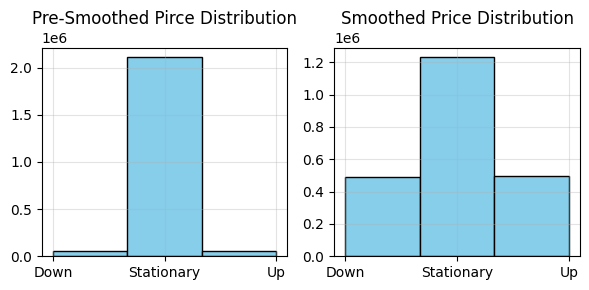

In [31]:
# Difference between price and smoohted price distirbution to handle imblanace and signal-to-noise 
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].hist(eth_book['PriceMove'], bins=3, color='skyblue', edgecolor='black')
ax[0].set_title('Pre-Smoothed Pirce Distribution')
ax[0].set_xticks([-1, 0, 1], labels=['Down', 'Stationary', 'Up'])
ax[0].grid(alpha=0.35)

ax[1].hist(eth_book['SmoothedPriceMove'], bins=3, color='skyblue', edgecolor='black')
ax[1].set_title('Smoothed Price Distribution')
ax[1].set_xticks([-1, 0, 1], labels=['Down', 'Stationary', 'Up'])
ax[1].grid(alpha=0.35)

plt.tight_layout()
plt.show()

#### Feature Selection and Data Splitting

We select features and remove the lookahead period. We then split the dataset into training and testing sets. Finally, we scale the features for stable training.

In [33]:
# Target column remains the same
target_col = 'SmoothedPriceMove'

# Start by including whichever features you already want:
feature_cols = []

# Price, volume, and order info
for level in range(1, LOB_LEVELS + 1):
    feature_cols.extend([
        f'BidPrice_{level}', f'AskPrice_{level}',  # Prices
        f'BidVolume_{level}', f'AskVolume_{level}',  # Volumes
        f'BidOrders_{level}', f'AskOrders_{level}'   # Order counts
    ])

feature_cols.extend([
    'BidArrivalRate', 'AskArrivalRate',
    'TradeVolume_Buy', 'TradeVolume_Sell',
    'NumTrades_Buy', 'NumTrades_Sell',
    'BinanceLargeTradeCount', 'Spread', 'RelativeSpread',
    'Microprice', 'VWAP', 'Lagged_BinanceTotalVolume',
    'Lagged_BinanceLargeTradeCount'
])

# Imbalances
for level in range(1, LOB_LEVELS + 1):
    feature_cols.append(f'bOF_{level}')
    feature_cols.append(f'aOF_{level}')

feature_cols.append('OF')

for level in range(1, LOB_LEVELS + 1):
    feature_cols.append(f'OFI_{level}')
feature_cols.append('OFI_Total')

X = eth_book[feature_cols].copy()
y = eth_book[target_col].copy()

In [35]:
# Remove lookahead bias
PREDICTION_HORIZON = 10
X = X.iloc[:-PREDICTION_HORIZON]
y = y.iloc[:-PREDICTION_HORIZON]

train_size = int(0.8 * len(X))
X_train_raw, X_test_raw = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

unique_labels = sorted(y_train.unique())
label_map = {val: idx for idx, val in enumerate(unique_labels)}
inv_label_map = {v: k for k, v in label_map.items()}

y_train_mapped = y_train.map(label_map).values
y_test_mapped = y_test.map(label_map).values

#### Preparing the Data for the Model

We define a `SequenceDataset` that returns windows of data (`WINDOW_SIZE` timesteps) and the label at the end of the window. This aligns with how we train recurrent models that process sequences.


In [36]:
WINDOW_SIZE = 100
BATCH_SIZE = 256
EPOCHS = 10
num_classes = len(unique_labels)

class SequenceDataset(Dataset):
    def __init__(self, X, y, window_size=100):
        self.X = X
        self.y = y
        self.window_size = window_size
        
    def __len__(self):
        return len(self.X) - self.window_size
    
    def __getitem__(self, idx):
        X_seq = self.X[idx:idx+self.window_size]  # (window_size, features)
        y_label = self.y[idx+self.window_size-1]  # Label at the end of sequence
        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_label, dtype=torch.long)

train_dataset = SequenceDataset(X_train_scaled, y_train_mapped, window_size=WINDOW_SIZE)
test_dataset = SequenceDataset(X_test_scaled, y_test_mapped, window_size=WINDOW_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

#### Defining the DeepLOB Model in PyTorch

- **Convolution layers:** Extract local patterns in LOB features.
- **Inception modules:** Identify patterns at multiple scales simultaneously.
- **LSTM layer:** Capture temporal evolution of these features over time.
- **Final layer:** Output class probabilities (up, down, stationary).

We use `LeakyReLU` activations and `Conv1d` layers. After convolution and inception steps, we run the features through an LSTM, then a final FC (fully connected) layer.

In [37]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, num_filters=32):
        super(InceptionModule, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, num_filters, kernel_size=1, padding=0)
        self.conv3 = nn.Conv1d(in_channels, num_filters, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels, num_filters, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.convpool = nn.Conv1d(in_channels, num_filters, kernel_size=1, padding=0)
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        c1 = self.leaky_relu(self.conv1(x))
        c3 = self.leaky_relu(self.conv3(x))
        c5 = self.leaky_relu(self.conv5(x))
        mp = self.pool(x)
        mp = self.leaky_relu(self.convpool(mp))
        out = torch.cat([c1, c3, c5, mp], dim=1)
        return out

class DeepLOBModel(nn.Module):
    def __init__(self, input_features, num_classes, window_size=100):
        super(DeepLOBModel, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.01)

        # Initial convolutions to reduce and reorganize features
        self.conv1 = nn.Conv1d(input_features, 16, kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv1d(16, 16, kernel_size=10, stride=1, padding=5)  # "same" padding

        # Inception modules to capture multi-scale temporal features
        self.inception1 = InceptionModule(in_channels=16, num_filters=32)
        self.inception2 = InceptionModule(in_channels=128, num_filters=32)  # 128 after first inception

        # LSTM to model temporal dependencies
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # x: (batch, window_size, features)
        x = x.transpose(1, 2)  # (batch, features, window_size)
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        
        x = self.inception1(x)
        x = self.inception2(x)

        x = x.transpose(1, 2)  # (batch, length, channels)
        _, (h, _) = self.lstm(x)
        h = h[-1]  # final hidden state
        out = self.fc(h)
        return F.log_softmax(out, dim=-1)

#### Training the Model

We use the Adam optimizer and NLLLoss for classification. We implement early stopping to avoid overfitting. At each epoch we
- train on the training set,
- validate on the test set, and
- if no improvement for a set number of epochs, we stop.

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLOBModel(input_features=X_train_scaled.shape[1], num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

best_val_acc = 0.0
patience = 5
no_improve_epochs = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
        pred = out.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += Xb.size(0)

    train_acc = correct / total
    train_loss = train_loss / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out, yb)
            val_loss += loss.item() * Xb.size(0)
            pred = out.argmax(dim=1)
            correct_val += (pred == yb).sum().item()
            total_val += Xb.size(0)

    val_acc = correct_val / total_val
    val_loss = val_loss / total_val

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_epochs = 0
        best_model_state = model.state_dict()
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("No improvement in validation accuracy for several epochs, stopping early.")
            break
        
model.load_state_dict(best_model_state)

Epoch 1/10, Train Loss: 0.4680, Train Acc: 0.8257, Val Loss: 0.5278, Val Acc: 0.7971
Epoch 2/10, Train Loss: 0.4451, Train Acc: 0.8351, Val Loss: 0.5112, Val Acc: 0.8028
Epoch 3/10, Train Loss: 0.4393, Train Acc: 0.8372, Val Loss: 0.5113, Val Acc: 0.8026
Epoch 4/10, Train Loss: 0.4351, Train Acc: 0.8384, Val Loss: 0.5076, Val Acc: 0.8036
Epoch 5/10, Train Loss: 0.4321, Train Acc: 0.8390, Val Loss: 0.5019, Val Acc: 0.8073
Epoch 6/10, Train Loss: 0.4290, Train Acc: 0.8401, Val Loss: 0.5108, Val Acc: 0.8040
Epoch 7/10, Train Loss: 0.4263, Train Acc: 0.8410, Val Loss: 0.5115, Val Acc: 0.8019
Epoch 8/10, Train Loss: 0.4237, Train Acc: 0.8415, Val Loss: 0.5117, Val Acc: 0.8024
Epoch 9/10, Train Loss: 0.4218, Train Acc: 0.8421, Val Loss: 0.5136, Val Acc: 0.8011
Epoch 10/10, Train Loss: 0.4198, Train Acc: 0.8428, Val Loss: 0.5193, Val Acc: 0.8012
No improvement in validation accuracy for several epochs, stopping early.


<All keys matched successfully>

#### Evaluation

PyTorch DeepLOB Model Classification Report:
              precision    recall  f1-score   support

          -1     0.8316    0.7091    0.7655    111229
           0     0.7616    0.9227    0.8344    218968
           1     0.8934    0.6562    0.7566    112683

    accuracy                         0.8012    442880
   macro avg     0.8289    0.7627    0.7855    442880
weighted avg     0.8127    0.8012    0.7973    442880



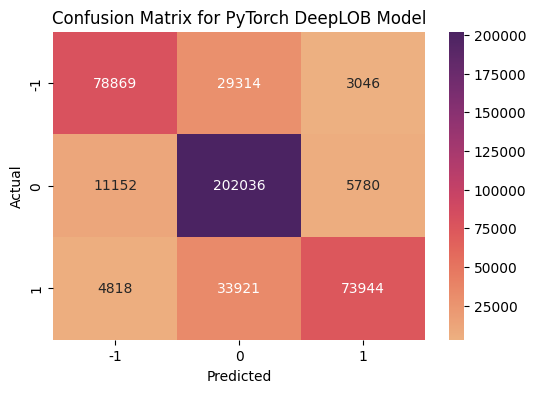

PyTorch DeepLOB Model Accuracy: 0.8012


In [39]:
# Evaluation on test set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        out = model(Xb)
        preds = out.argmax(dim=1).cpu().numpy()
        targets = yb.cpu().numpy()
        all_preds.append(preds)
        all_targets.append(targets)
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

y_pred_original = np.array([inv_label_map[val] for val in all_preds])
y_true_original = np.array([inv_label_map[val] for val in all_targets])

acc = accuracy_score(y_true_original, y_pred_original)
print("PyTorch DeepLOB Model Classification Report:")
print(classification_report(y_true_original, y_pred_original, digits=4))

conf = confusion_matrix(y_true_original, y_pred_original)
plt.figure(figsize=(6,4))
sns.heatmap(conf, annot=True, fmt='d', cmap='flare', 
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for PyTorch DeepLOB Model')
plt.show()

print(f"PyTorch DeepLOB Model Accuracy: {acc:.4f}")

#### Saving the Model and Scaler
Finally, we save the trained model parameters and the scaler so we can reuse them later for inference or further training.

In [40]:
# Save model and scaler
torch.save(model.state_dict(), 'deeplob_pytorch_model.pt')
joblib.dump(scaler, 'scaler_deeplob.joblib')

['scaler_deeplob.joblib']